In [21]:
import os
from datascience import *

videos_dir = '/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/game-replays/720'
player_pos_dir = 'demo'

video_paths = [os.path.join(videos_dir, f) for f in os.listdir(videos_dir)]
player_pos_paths = [os.path.join(player_pos_dir, f) for f in os.listdir(player_pos_dir)]

unique_vids = {}
unique_pos = {}

# map all video ids to video paths
for v in video_paths:
    vid_id = v.split('/')[-1].split('_')[0]
    period = v.split('/')[-1].split('_')[-1].split('period')[1].replace('.mp4', '')
    vid_id += f'_{period}'
    unique_vids[vid_id] = v

# map all position ids to paths
for p in player_pos_paths:
    p_id = p.split('.')[3]
    period = p.split('.')[4][1]
    p_id += f'_{period}'
    unique_pos[p_id] = p

shared_ids = []
vid_fps = []
pos_fps = []

# find all shared ids
for k in unique_vids:
    if k in unique_pos:
        shared_ids.append(k)
        vid_fps.append(unique_vids[k])
        pos_fps.append(unique_pos[k])

In [22]:
# create a table with all file paths mapped to game ids
mapped_paths = Table().with_columns(
    'ids', shared_ids,
    'video_paths', vid_fps,
    'postion_paths', pos_fps
)
mapped_paths

ids,video_paths,postion_paths
18021_3,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,demo/11-18-2015.GSW.TOR.18021.Q3.2D-POS.json


In [3]:
import cv2
import json

vid_path = mapped_paths.rows[0][1]
pos_path = mapped_paths.rows[0][2]
dst = 'viz.mp4'

# cap = cv2.VideoCapture(vid_path)
with open(pos_path, 'r') as f:
    positions = json.load(f)

100%|█████████▉| 38876/38881 [15:03<00:00, 44.05it/s]

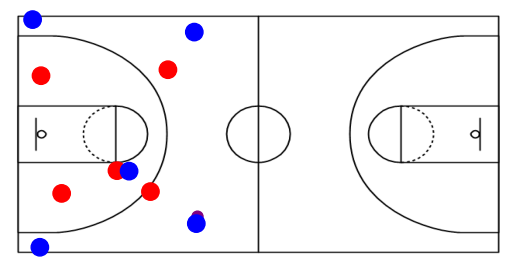

In [4]:
# we will animate the player positions here
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
%matplotlib inline

# court
court = plt.imread('court.png')

# figure
fig = plt.figure()

# axis
ax = plt.axes(
    xlim = (0, 100),
    ylim = (0, 50),
    )

def plot_players(i):
    '''
    Plot ball + player positions for a given frame i.
    '''
    
    ax.clear()  # Clear previous frame drawings
    ax.imshow(court, extent=[0, 100, 0, 50])  # Redraw the court
    ax.axis("off")  # Turn off the axis
    team_ids = {}

    # handle none values
    if positions[str(i)] == None:
        return ax.patches

    player_pos = positions[str(i)]['player_positions']

    for pos in player_pos:
        team_id = pos['team_id']
        if team_id not in team_ids:
            if len(team_ids) == 0:
                team_ids[team_id] = 'purple'
            elif len(team_ids) == 1:
                team_ids[team_id] = 'red'
            else:
                team_ids[team_id] = 'blue'
        color = team_ids[team_id]
        x = pos['x_position']
        y = pos['y_position']
        z = pos['z_position']
        if z <= 1:
            z = 1
        circle = plt.Circle((x, y), 1.75 / z, color=color)
        ax.add_patch(circle)
    return ax.patches

frame_count = len(positions)
frames = tqdm(range(frame_count))
anim = FuncAnimation(fig, plot_players,
                     frames = frames, interval = 0, blit = True) 
anim.save('test.mp4',  
          writer = 'ffmpeg', fps = 30)

In [6]:
from moviepy.editor import VideoFileClip, clips_array

def concatenate_videos(video_path1, video_path2, output_path):
    # Load the videos
    clip1 = VideoFileClip(video_path1)
    clip2 = VideoFileClip(video_path2)

    # Resize videos to match their heights
    height = min(clip1.size[1], clip2.size[1])
    clip1_resized = clip1.resize(height=height)
    clip2_resized = clip2.resize(height=height)

    # Concatenate videos side-by-side
    final_clip = clips_array([[clip1_resized, clip2_resized]])

    # Write the result to a file
    final_clip.write_videofile(output_path, codec='libx264')

# Example usage
# concatenate_videos(vid_path, 'test.mp4', 'concat_viz.mp4')
vid_path

'/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/game-replays/720/18021_11-18-2015_2_Golden State Warriors_78_Toronto Raptors_period1.mp4'